# 필요한 라이브러리 설치 & import

In [ ]:
!pip install pi-heaan

In [1]:
!pip show pi-heaan 

Name: pi-heaan
Version: 3.4.1.3
Summary: pi-HEaaN is a simulator to HEaaN API, the library of CKKS scheme
Home-page: UNKNOWN
Author: Cryptolab Inc.
Author-email: cryptolab@cryptolab.co.kr
License: UNKNOWN
Location: /Users/juheeyoon/anaconda3/lib/python3.10/site-packages
Requires: 
Required-by: 


In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import piheaan as heaan
import matplotlib.pyplot as plt

---

# 준비

- 동형 암호화를 위한 매개 변수와 컨텍스트 설정
- 동형 연산을 사용하기 위한 비밀키와 공개키 생성
    - 공개키 : 메시지를 암호문으로 암호화 $\Rightarrow$ 암호문에 대해 동형 연산 수행
    - 비밀키 : 암호문을 복호화하기 위함

In [3]:
# 매개변수 & 컨텍스트 설정
params = heaan.ParameterPreset.FGb
context = heaan.make_context(params)

In [4]:
# 비밀키, 공개키 생성

# 비밀키 생성
sk = heaan.SecretKey(context)
# 키 생성기 인스턴스 초기화
keygen = heaan.KeyGenerator(context, sk)
# 키 생성기를 사용하여 일반적으로 필요한 키들 생성
keygen.gen_common_keys()
# 생성된 키 팩(keypack) 중 공개키(public_key)
public_key = keygen.keypack

In [5]:
log_slots = 14
num_slots = 2 ** log_slots

---

# 학습용 데이터 준비

In [6]:
housing = fetch_california_housing()

In [7]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [8]:
X = housing.data[:num_slots]
y = housing.target[:num_slots]
feature_names = housing.feature_names

print('원본 데이터:')
print(' X: ', X.shape)
print(' y: ', y.shape)
print('항목 이름: ', feature_names)

원본 데이터:
 X:  (16384, 8)
 y:  (16384,)
항목 이름:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [9]:
X_medinc = X[:, feature_names.index('MedInc')]     # Medlnc 데이터
print('MedInc 데이터:', X_medinc.shape)
print(X_medinc)

MedInc 데이터: (16384,)
[8.3252 8.3014 7.2574 ... 2.8523 2.375  4.4871]


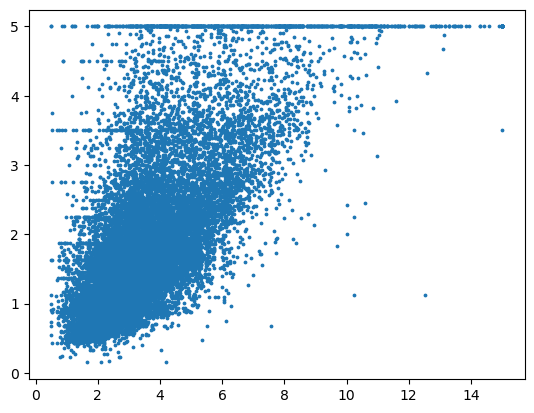

Max MedInc : 15.000100, Min MedInc : 0.499900
Max price : 5.000010, Min price : 0.149990


In [10]:
# X = MedInc 데이터 / y = target(price)
plt.scatter(X_medinc, y, s = 3)
plt.show()
print('Max MedInc : %f, Min MedInc : %f' %(max(X_medinc), min(X_medinc)))
print('Max price : %f, Min price : %f' %(max(y), min(y)))

In [11]:
w0 = np.ones( (num_slots, ) )
w1 = np.ones( (num_slots, ) )

---

# 암호화

In [12]:
# 반복 횟수
iters = 2000

# 학습률
alpha = 0.01

In [13]:
message_x = heaan.Message(log_slots)
message_y = heaan.Message(log_slots)
message_w0 = heaan.Message(log_slots)
message_w1 = heaan.Message(log_slots)

for i in range(len(y)):
    message_x[i] = X_medinc[i]
    message_y[i] = y[i]
    message_w0[i] = w0[i]
    message_w1[i] = w1[i]

In [14]:
x = heaan.Ciphertext(context)
y = heaan.Ciphertext(context)
w0 = heaan.Ciphertext(context)
w1 = heaan.Ciphertext(context)
yp = heaan.Ciphertext(context)
yd = heaan.Ciphertext(context)

enc = heaan.Encryptor(context)

enc.encrypt(message_x, public_key, x)
enc.encrypt(message_y, public_key, y)
enc.encrypt(message_w0, public_key, w0)
enc.encrypt(message_w1, public_key, w1)

---

# 선형 회귀 모델 학습

In [15]:
eval = heaan.HomEvaluator(context, public_key)
dec = heaan.Decryptor(context)

In [16]:
print(dir(eval))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'add', 'bootstrap', 'bootstrap_extended', 'conjugate', 'i_mult', 'integer_mult', 'kill_imag', 'left_rotate', 'left_rotate_reduce', 'level_down', 'level_down_one', 'min_level_for_bootstrap', 'min_level_for_bootstrap_extended', 'mult', 'mult_without_rescale', 'negate', 'relinearize', 'rescale', 'right_rotate', 'right_rotate_reduce', 'rot_sum', 'square', 'sub', 'tensor']


#### 동형 암호화에서의 암호문 레벨은 연산이 수행될 때마다 감소한다. 특히, 곱셈 연산은 레벨을 크게 감소시킨다. 
#### $\Rightarrow$ 레벨이 0이 되면 그 암호문에 대한 추가적인 곱셈 연산이 불가능!
<br>

#### 해결 방법 중 하나는 bootstrap 연산을 사용하는 것이다. Bootstrap은 암호문의 레벨을 다시 높이는 연산임!

In [17]:
heaan.make_bootstrappable(context)

#### 공부용 : 홰전 연산이 필요한 이유 (From ChatGPT)

- 회전 연산은 동형 암호화의 중요한 연산 중 하나입니다. 이는 암호화된 데이터의 슬롯 간 위치를 변경할 수 있게 해 주기 때문에 다양한 연산을 가능하게 합니다.

- sum 함수의 맥락에서 보면, 회전 연산을 사용하는 주요 이유는 각 슬롯의 값을 전체 슬롯에 합산하기 위해서입니다.

- 예를 들어, 암호화된 데이터가 4개의 슬롯 [a, b, c, d]를 갖고 있다고 가정합시다. 이 모든 값을 합산하여 각 슬롯에 동일한 값 (a+b+c+d)을 얻고 싶습니다.

- 이를 위해 다음 단계를 따릅니다:

> 원래 데이터를 한 슬롯 왼쪽으로 회전하여 [b, c, d, a]를 얻습니다.<br>
원래 데이터와 회전된 데이터를 더하여 [a+b, b+c, c+d, d+a]를 얻습니다.<br>
이 결과를 다시 두 슬롯 왼쪽으로 회전하여 [c+d, d+a, a+b, b+c]를 얻습니다.<br>
두 결과를 더하면 [a+b+c+d, b+c+d+a, c+d+a+b, d+a+b+c]를 얻습니다.<br>

- 이처럼 회전 연산을 사용하면 암호화된 상태에서 슬롯 간 값을 교환하거나 합산하는 것이 가능합니다. 특히, 벡터나 행렬과 같은 구조화된 데이터를 다룰 때 회전 연산은 매우 중요하게 사용됩니다.

#### sum 함수 목적 : result의 각 슬롯에 동일한 값을 갖도록 하는 방식으로 합산을 수행

In [18]:
def sum(ciphertext:heaan.Ciphertext):
    result = heaan.Ciphertext(context)
    result = ciphertext

    for i in range(log_slots):
        temp_sum = heaan.Ciphertext(context)
        
        
        eval.left_rotate(result, 2**i, temp_sum)
        eval.add(result, temp_sum, result)

    return result

In [19]:
print(dir(keygen))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'flush', 'gen_common_keys', 'gen_conj_key', 'gen_enc_key', 'gen_left_rot_key', 'gen_mult_key', 'gen_right_rot_key', 'gen_rot_key_bundle', 'keypack', 'save']


In [26]:
# 회전 키 에러로, 모든 가능한 회전 키 생성
for i in range(1, 2**log_slots):
    keygen.gen_left_rot_key(i)
keygen.gen_left_rot_key(20480)

In [27]:
for k in range(iters):
    temp = heaan.Ciphertext(context)

    # 예측값 계산 : yp = w0*x + w1
    eval.mult(x, w0, temp)
    eval.bootstrap(temp, temp)
    eval.add(temp, w1, yp)

    # 오차 계산 : yd = yp - yt
    eval.sub(yp, y, yd)
        
    # 경사하강법 적용 : 손실함수의 미분
    # w0 update
    # (x.T @ yd)
    eval.mult(x, yd, temp)
    eval.bootstrap(temp, temp)
    temp = sum(temp)

    # alpha * (x.T @ yd) / M
    eval.mult(temp, alpha/num_slots, temp)
    eval.bootstrap(temp, temp)
    
    # w = w - alpha * (x.T @ yd) / M
    eval.sub(w0, temp, w0)
    
    # w1 update
    # (x.T @ yd)
    eval.mult(yd, 1, temp)
    eval.bootstrap(temp, temp)
    temp = sum(temp)

    # alpha * (x.T @ yd) / M
    eval.mult(temp, alpha/num_slots, temp)
    eval.bootstrap(temp, temp)
    
    # w = w - alpha * (x.T @ yd) / M
    eval.sub(w1, temp, w1)

    # Iteration 100번대마다 출력
    if((k == 0) or ((k+1) % 100 == 0)):
        w0_decrypt      = heaan.Message(log_slots)
        w1_decrypt   = heaan.Message(log_slots)
        loss = heaan.Message(log_slots)
        
        # np.mean(yd ** 2) / 2
        eval.mult(yd, yd, temp)
        eval.bootstrap(temp, temp)
        temp = sum(temp)
        eval.mult(temp, 1/(2*num_slots), temp)
        eval.bootstrap(temp, temp)

        # loss 값 복호화
        dec.decrypt(temp, sk, loss)
        
        # w0, w1 복호화
        dec.decrypt(w0, sk, w0_decrypt)
        dec.decrypt(w1, sk, w1_decrypt)
        
        print("Iteration = %4d | w0 = %f | w1 = %f | loss = %f" % (k+1, float(np.real(w0_decrypt[0])), float(np.real(w1_decrypt[0])), float(np.real(loss[0]))))

Iteration =    1 | w0 = 0.873491 | w1 = 0.972216 | loss = 4.830099
Iteration =  100 | w0 = 0.340265 | w1 = 0.790632 | loss = 0.364140
Iteration =  200 | w0 = 0.351853 | w1 = 0.736403 | loss = 0.361047
Iteration =  300 | w0 = 0.361463 | w1 = 0.691437 | loss = 0.358921
Iteration =  400 | w0 = 0.369431 | w1 = 0.654150 | loss = 0.357459
Iteration =  500 | w0 = 0.376038 | w1 = 0.623232 | loss = 0.356453
Iteration =  600 | w0 = 0.381516 | w1 = 0.597595 | loss = 0.355762
Iteration =  700 | w0 = 0.386059 | w1 = 0.576336 | loss = 0.355287
Iteration =  800 | w0 = 0.389826 | w1 = 0.558708 | loss = 0.354960
Iteration =  900 | w0 = 0.392950 | w1 = 0.544091 | loss = 0.354735
Iteration = 1000 | w0 = 0.395540 | w1 = 0.531970 | loss = 0.354581
Iteration = 1100 | w0 = 0.397688 | w1 = 0.521920 | loss = 0.354474
Iteration = 1200 | w0 = 0.399469 | w1 = 0.513586 | loss = 0.354401
Iteration = 1300 | w0 = 0.400946 | w1 = 0.506676 | loss = 0.354351
Iteration = 1400 | w0 = 0.402170 | w1 = 0.500945 | loss = 0.35

---

# 회귀 직선 그려보기

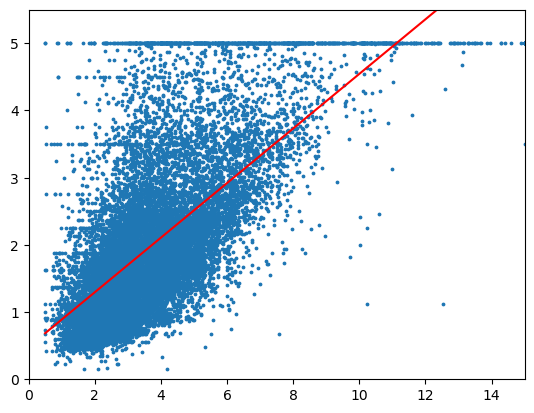

In [35]:
# X = MedInc 데이터 / y = target(price)
X_medinc = X[:, feature_names.index('MedInc')]     # Medlnc 데이터
y = housing.target[:num_slots]
xval = np.arange(min(X_medinc), max(X_medinc), 1)

plt.scatter(X_medinc, y, s = 3)
plt.plot(xval, xval*float(np.real(w0_decrypt[0]))+float(np.real(w1_decrypt[0])), c='r')
plt.xlim(0,15) ; plt.ylim(0,5.5)
plt.show()